In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import time
seed = 0
torch.manual_seed(seed)

from torch.utils.tensorboard import SummaryWriter
# Tensorboard name to write
experiment_name='sequential_RLHF_SFT_1D'
writer = SummaryWriter(f'runs/{experiment_name}')

In [2]:
# Define the neural network with softmax actication
class SoftmaxNN(nn.Module):
    def __init__(self):
        super(SoftmaxNN, self).__init__()
        self.hidden = nn.Conv1d(in_channels=1, 
              out_channels=1, 
              kernel_size=2, 
              stride=2,
              bias=False) # 1D Conv layer to mimic softmax parameterization
        self.activation = nn.Softmax(dim=1)
        self._init_weight()
        # DEBUG
        # self.x = None
        # self.x_activated = None

    def forward(self, x, activation=False):
        x = self.hidden(x)
        # DEBUG
        # self.x =x
        if activation:
            x = self.activation(x.squeeze())
            # DEBUG
            # self.x_activated = x
        return x
    
    def _init_weight(self):
        init_weights = np.array([5.0, -9.9], dtype=np.float32)
        with torch.no_grad():
            self.hidden.weight = nn.Parameter(torch.tensor(init_weights).unsqueeze(0).unsqueeze(0))
    def set_params(self,params):
        init_weights = np.array(params, dtype=np.float32)
        with torch.no_grad():
            self.hidden.weight = nn.Parameter(torch.tensor(init_weights).unsqueeze(0).unsqueeze(0))


def get_weight(model):
    weight_list =[]
    for name, param in model.named_parameters():
        weight_list.append(param.view(-1).detach().numpy())
    return np.array(weight_list).flatten()
    

In [3]:
# SFT dataset
X1 = torch.tensor([[[1.0, 1.0, 0.5, 0.5]], [[1.0, 0.5, 0, 0.5]]])
y = torch.tensor([0, 1])  

# DPO dataset
X2 = torch.tensor([[[0.5, 1.0, 1.0, 1.0]], [[1.0, 0.5, 0.5, 0.5]]])
yw = torch.tensor([0, 1.0])
yl = 1-yw  

In [4]:
# Learning parameters
mu=0.0 # weight decay
epochs = 10000 #575 When theta hat passes 0.
epochs_ref = 2000
thresh=0.05
alpha=1.0
lr=1e-2 #alpha/np.sqrt(epochs)

# TRAIN REFERENCE MODEL

print()
print("REFERNCE MODEL TRAINING")

# Instantiate the model
model_ref = SoftmaxNN()
print('ref model params origin')
print(get_weight(model_ref))
# Define the loss function and optimizer
f1 = nn.NLLLoss()  # Negative Log Likelihood loss
logsoftmax = nn.LogSoftmax(dim=1) # Log(softmax())
optimizer = optim.Adam(model_ref.parameters(), lr=lr, weight_decay=mu)

### train ref model on SFT
for epoch in range(epochs_ref):
    model_ref.train()
    
    # Forward pass
    outputs = model_ref(X2, activation=False)
    loss = f1(logsoftmax(outputs.squeeze()), yw.long()) #SFT
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs_ref}], Loss: {loss.item():.4f}')


print('ref model params after train')
print(get_weight(model_ref))


REFERNCE MODEL TRAINING
ref model params origin
[ 5.  -9.9]
Epoch [1000/2000], Loss: 0.2664
Epoch [2000/2000], Loss: 0.0670
ref model params after train
[-5.3395834 -9.937505 ]


In [5]:
# model_ref.set_params([-5.1, -9.1])
print('ref model params after train')
print(get_weight(model_ref))

ref model params after train
[-5.3395834 -9.937505 ]


In [6]:
# ALIGNMENT
model_ref.eval()
beta = 1.0
def dpo_loss(pi, X=X2, yw=yw, yl=yl, pi_ref=model_ref, beta=1.0,reg_lmbda = 0.01):
    # pi is model
    T1 = torch.gather(pi(X, activation=True), 1, yw.long().unsqueeze(1)).squeeze()
    T2 = torch.gather(pi(X, activation=True), 1, yl.long().unsqueeze(1)).squeeze()
    T3 = torch.gather(pi_ref(X, activation=True), 1, yw.long().unsqueeze(1)).squeeze()
    T4 = torch.gather(pi_ref(X, activation=True), 1, yl.long().unsqueeze(1)).squeeze()
    loss=-torch.mean(torch.log(torch.sigmoid(beta*torch.log((T1/T2)/(T3/T4)))).view(-1))
    l2_norm = torch.sum(model.hidden.weight.flatten()**2)
    loss += reg_lmbda * l2_norm
    return loss


def expected_preference(pi, X=X2, yw=yw, yl=yl, pi_ref=model_ref, beta=1.0):
    T1 = torch.gather(pi(X, activation=True), 1, yw.long().unsqueeze(1)).squeeze()
    T2 = torch.gather(pi(X, activation=True), 1, yl.long().unsqueeze(1)).squeeze()
    T3 = torch.gather(pi_ref(X, activation=True), 1, yw.long().unsqueeze(1)).squeeze()
    T4 = torch.gather(pi_ref(X, activation=True), 1, yl.long().unsqueeze(1)).squeeze()

    return torch.mean(torch.sigmoid(beta*torch.log((T1/T2)/(T3/T4))).view(-1))

def sft_loss(model,X1=X1, y=y,reg_lmbda = 0.01):
    f1 = nn.NLLLoss()  # Negative Log Likelihood loss
    logsoftmax = nn.LogSoftmax(dim=1) # Log(softmax())
    outputs = model(X1, activation=False)
    loss = f1(logsoftmax(outputs.squeeze()), y)
    # L2 regularization term: sum of squared parameters
    l2_norm = torch.sum(model.hidden.weight.flatten()**2)
    loss += reg_lmbda * l2_norm

    return loss

In [7]:

# Assume model, model_ref, dpo_loss, f1, logsoftmax, X1, X2, y, yw, yl, mu, beta are defined

model=SoftmaxNN()
print(get_weight(model))
Xx = np.linspace(-12, 15, 51)
Yy = np.linspace(-12, 15, 51)
W1, W2 = np.meshgrid(Xx, Yy)
Z = np.zeros_like(W1)
Z_2=np.zeros_like(W1)
Z1_star=[]
idx=[]
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        model.set_params([W1[i,j],W2[i, j]])
        
        outputs = model(X1)
        loss = dpo_loss(model)
        loss_sft = sft_loss(model)
        
        Z[i, j] = loss.item()
        Z_2[i, j] = loss_sft.item()
    
    idx.append(np.argmin(Z_2[i,:]))
    Z1_star.append(Z[i,idx[-1]])

[ 5.  -9.9]


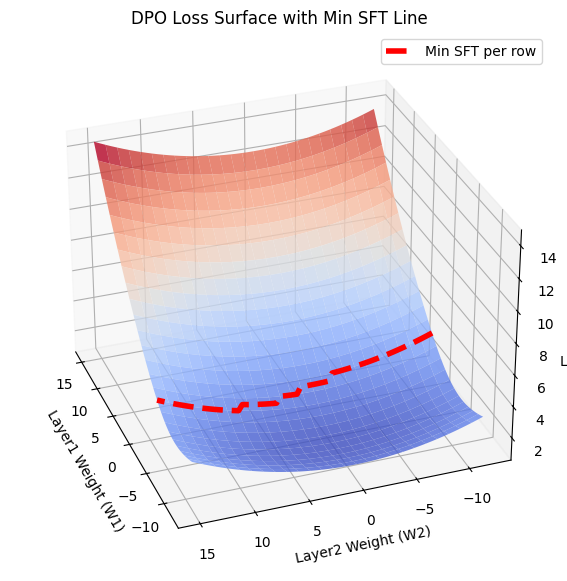

In [8]:
# Convert to arrays for plotting
idx = np.array(idx)
Z1_star = np.array(Z1_star)

# Compute the coordinates of the red dashed line
line_x = Xx #W1[np.arange(W1.shape[0]), idx]
line_y = Yy[idx] #np.arange() #W2[np.arange(W2.shape[0]), idx]
line_z = Z1_star

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface of Z (DPO loss)
ax.plot_surface(W1, W2, Z, cmap=cm.coolwarm, edgecolor='none', alpha=0.8)

# Red dashed line of the minimum sft loss along each W1 row
ax.plot( line_y, line_x,line_z, 'r--', label='Min SFT per row', linewidth=4,zorder=20)

ax.set_xlabel('Layer1 Weight (W1)')
ax.set_ylabel('Layer2 Weight (W2)')
ax.set_zlabel('Loss')
ax.set_title('DPO Loss Surface with Min SFT Line')
ax.legend()
ax.view_init(elev=30, azim=160)
plt.show()

In [9]:
def min_LL_SFT(
    model_sft, 
    gam_inv = 1/16, 
    num_epoch = 500, 
    eps = 0,
    thresh = 1e-2,
    lr=lr,
    weight_decay=mu,
    LL_layer_name='layer2'):
    
    # for name, param in model_sft.named_parameters():
    #     print(name, param)
    optimizer = optim.SGD(model_sft.parameters(), lr=lr, weight_decay=mu)

    weight_traj=[]
    loss_0=10000
    for epoch in range(num_epoch):
        
        model_sft.train()

        loss = sft_loss(model_sft)+gam_inv*dpo_loss(model_sft)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # Manually freeze one weight (e.g., the 1st one)
        with torch.no_grad():
            model.hidden.weight.grad[0, 0, 0] = 0.0 
                
        optimizer.step()
        
        if (epoch+1) % 20 == 0:
            print(f'Innerloop: Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')
        if loss.item() <= thresh:
            break    
        # record weight trajectory
        weight_traj.append(get_weight(model_sft))
    return weight_traj

In [10]:
def PBGD(
    model, 
    gam=16, 
    num_epoch=1000,
    num_inner_epoch=10,
    eps=1e-2,
    thresh=1e-2,
    lr=1e-2,
    inner_lr=1e-2,
    weight_decay=1e-2,
):
    model.train()
    
    x_yg_y_gam_list = []
    time_list=[]
    
    weight_traj=[]
    loss_0=10000
    weight_g=weight_gam =get_weight(model)
    model.train()
    start_time = time.time()
    for epoch in range(num_epoch):
        weight_start = get_weight(model)
        # find y g
        model.set_params([weight_start[0],weight_g[1]])
        min_LL_SFT(model,gam_inv = 0, num_epoch = num_inner_epoch)
        weight_g=get_weight(model)
        # print(weight_g)

        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=mu)
        #record nabla x g(x,yg)
        loss_g = sft_loss(model)
        optimizer.zero_grad()
        loss_g.backward()
        with torch.no_grad():
            grad_g = model.hidden.weight.grad[0, 0, 0].item()
            # print("grad_g",grad_g)

        # find y gam
        model.set_params([weight_start[0],weight_gam[1]])
        min_LL_SFT(model,gam_inv = 1/gam, num_epoch = num_inner_epoch)
        weight_gam=get_weight(model)

        # print(weight_gam)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=mu)

        loss_g = sft_loss(model)
        loss_f = dpo_loss(model)
        loss = loss_f + gam*loss_g
        
        optimizer.zero_grad()
        loss.backward()
        
        # Manually freeze one weight (e.g., the 1st one)
        with torch.no_grad():
            # print(model.hidden.weight.grad)
            model.hidden.weight.grad[0, 0, 1] = 0.0 
            model.hidden.weight.grad[0, 0, 0] -= gam* grad_g
            # print(model.hidden.weight.grad)
                
        optimizer.step()
        # print(get_weight(model))
        
        if (epoch+1) % 100 == 0:
            print(f'Outer loop: Epoch [{epoch+1}/{num_epoch}], model weight:{get_weight(model)}, DPO Loss {loss_f.item():.4f}, SFT Loss: {loss_g.item():.4f}')
        if loss.item() <= thresh:
            break    
        # record weight trajectory
        weight_traj.append(get_weight(model))
        x_yg_y_gam_list.append([weight_start[0],weight_g[1],weight_gam[1]])
        time_list.append(time.time()-start_time)
    return weight_traj,x_yg_y_gam_list, time_list

In [11]:
def PBGD_Free(
    model, 
    gam=16, 
    num_epoch=1000,
    num_inner_epoch=2,
    eps=1e-2,
    thresh=1e-2,
    lr=1e-2,
    inner_lr=1e-2,
    weight_decay=1e-2,
):
    model.train()
    

    weight_traj=[]
    time_list = []
    loss_0=10000
    weight_gam=get_weight(model)
    model.train()
    start_time = time.time()
    for epoch in range(num_epoch):
        weight_start = get_weight(model)
        # find y gam
        model.set_params([weight_start[0],weight_gam[1]])
        min_LL_SFT(model,gam_inv = 1/gam, num_epoch = num_inner_epoch)
        weight_gam=get_weight(model)

        # print(weight_gam)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=mu)

        loss_g = sft_loss(model)
        loss_f = dpo_loss(model)
        loss = loss_f #+ gam*loss_g
        
        optimizer.zero_grad()
        loss.backward()
        
        # Manually freeze one weight (e.g., the 1st one)
        with torch.no_grad():
            # print(model.hidden.weight.grad)
            model.hidden.weight.grad[0, 0, 1] = 0.0 
            # model.hidden.weight.grad[0, 0, 0] -= gam* grad_g
            # print(model.hidden.weight.grad)
                
        optimizer.step()
        # print(get_weight(model))
        
        if (epoch+1) % 100 == 0:
            print(f'Outer loop: Epoch [{epoch+1}/{num_epoch}], model weight:{get_weight(model)} DPO Loss {loss_f.item():.4f}, SFT Loss: {loss_g.item():.4f}')
        if loss.item() <= thresh:
            break    
        # record weight trajectory
        weight_traj.append(get_weight(model))
        time_list.append(time.time()-start_time)
    return weight_traj,time_list

In [12]:
model = SoftmaxNN()
print(get_weight(model),"sft:",sft_loss(model).item())
traj1, x_yg_y_gam_list,time1 =PBGD(model,lr=1e-2,num_epoch=5000)
print(get_weight(model),"sft:",sft_loss(model).item())

[ 5.  -9.9] sft: 4.999843597412109
Outer loop: Epoch [100/5000], model weight:[ 4.394049  -6.1573763], DPO Loss 5.4503, SFT Loss: 3.3919
Outer loop: Epoch [200/5000], model weight:[ 3.7733383 -3.6607478], DPO Loss 4.8468, SFT Loss: 2.5099
Outer loop: Epoch [300/5000], model weight:[ 3.1659746 -2.0273705], DPO Loss 4.4116, SFT Loss: 1.9719
Outer loop: Epoch [400/5000], model weight:[ 2.583167   -0.90395474], DPO Loss 4.0582, SFT Loss: 1.5849
Outer loop: Epoch [500/5000], model weight:[ 2.0247    -0.0873227], DPO Loss 3.7510, SFT Loss: 1.2786
Outer loop: Epoch [600/5000], model weight:[1.4891213 0.5360505], DPO Loss 3.4745, SFT Loss: 1.0282
Outer loop: Epoch [700/5000], model weight:[0.9755387 1.0335068], DPO Loss 3.2219, SFT Loss: 0.8255
Outer loop: Epoch [800/5000], model weight:[0.4835777 1.4470644], DPO Loss 2.9902, SFT Loss: 0.6678
Outer loop: Epoch [900/5000], model weight:[0.01317307 1.8036621 ], DPO Loss 2.7776, SFT Loss: 0.5526
Outer loop: Epoch [1000/5000], model weight:[-0.435

In [13]:
model = SoftmaxNN()
print(get_weight(model),"sft:",sft_loss(model).item())
traj2,time2=PBGD_Free(model,lr=1e-2,num_epoch=40000)
print(get_weight(model),"sft:",sft_loss(model).item())

[ 5.  -9.9] sft: 4.999843597412109
Outer loop: Epoch [100/40000], model weight:[ 4.409153 -9.039921] DPO Loss 5.8970, SFT Loss: 4.4291
Outer loop: Epoch [200/40000], model weight:[ 3.8311007 -8.220729 ] DPO Loss 5.4213, SFT Loss: 3.9010
Outer loop: Epoch [300/40000], model weight:[ 3.2659147 -7.440647 ] DPO Loss 4.9796, SFT Loss: 3.4159
Outer loop: Epoch [400/40000], model weight:[ 2.7137494 -6.697888 ] DPO Loss 4.5696, SFT Loss: 2.9729
Outer loop: Epoch [500/40000], model weight:[ 2.174851 -5.990666] DPO Loss 4.1893, SFT Loss: 2.5720
Outer loop: Epoch [600/40000], model weight:[ 1.6495699 -5.317222 ] DPO Loss 3.8371, SFT Loss: 2.2149
Outer loop: Epoch [700/40000], model weight:[ 1.1383678 -4.675839 ] DPO Loss 3.5116, SFT Loss: 1.9038
Outer loop: Epoch [800/40000], model weight:[ 0.64182615 -4.0648637 ] DPO Loss 3.2115, SFT Loss: 1.6411
Outer loop: Epoch [900/40000], model weight:[ 0.16063853 -3.482719  ] DPO Loss 2.9359, SFT Loss: 1.4277
Outer loop: Epoch [1000/40000], model weight:[-

In [14]:
traj3,time3=traj2,time2

In [15]:
# Assume model, model_ref, dpo_loss, f1, logsoftmax, X1, X2, y, yw, yl, mu, beta are defined
model=SoftmaxNN()
print(get_weight(model))
Xx = np.linspace(-12, 15, 51)
Yy = np.linspace(-12, 15, 51)
Q1, Q2 = np.meshgrid(Xx, Yy)
Z = np.zeros_like(Q1)
Z_2=np.zeros_like(Q2)
Z1_star=[]
idx=[]
Y_star_x=[]
for i in range(Q1.shape[0]):
    for j in range(Q2.shape[1]):
        # print([Xx[i],Yy[j]])
        model.set_params([Xx[i],Yy[j]])
        
        loss_dpo = dpo_loss(model)
        loss_sft = sft_loss(model)
        
        Z[i, j] = loss_dpo.item()
        Z_2[i, j] = loss_sft.item()
    idx.append(np.argmin(Z_2[i,:]))
    Y_star_x.append(Yy[idx[-1]])
    Z1_star.append(Z[i,idx[-1]])

[ 5.  -9.9]


In [16]:
# Compute the coordinates of the red dashed line
line_x = Xx #W1[np.arange(W1.shape[0]), idx]
line_y = Y_star_x #np.arange() #W2[np.arange(W2.shape[0]), idx]
line_z = Z1_star

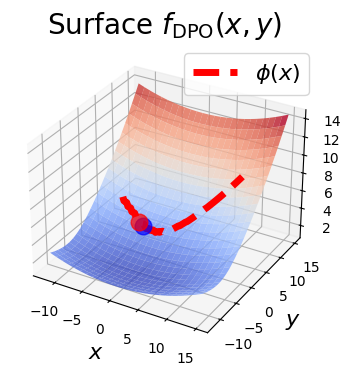

In [17]:
# Plot
fig = plt.figure(figsize=(4, 4.5))
ax = fig.add_subplot(111, projection='3d')

# Surface of Z (DPO loss)
ax.plot_surface(Q1, Q2, Z, cmap=cm.coolwarm, edgecolor='none', alpha=0.8)

# Red dashed line for min SFT
ax.plot(
    line_x, line_y, line_z,
    'r--',
    label=r'$\phi(x)$',
    linewidth=5,  # ⬅️ Increased line width
    zorder=20
)

model=SoftmaxNN()
model.set_params(traj1[-1])
dpo1=dpo_loss(model)
model.set_params(traj2[-1])
dpo2=dpo_loss(model)
# Dots at traj1[-1] and traj2[-1]
ax.plot(traj1[-1][0], traj1[-1][1], dpo1.item(), "o", color="b", alpha=0.7,markersize=12, zorder=50)
ax.plot(traj2[-1][0], traj2[-1][1], dpo2.item(), "o", color="r", alpha=0.7,markersize=12, zorder=50)

# Labels with increased font size

# ax.set_zlabel('Loss', fontsize=16)
ax.set_title(r'Surface $f_{\mathrm{DPO}}(x,y)$', fontsize=20)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$y$', fontsize=16)
ax.legend(fontsize=16)

# View angle
# ax.view_init(elev=30, azim=160)

plt.savefig("dpo_sft_example_toy.pdf",bbox_inches='tight')
plt.show()


In [18]:
idx_star = np.argmin(line_z)
theta_1_star = line_x[idx_star]
theta_2_star = line_y[idx_star]

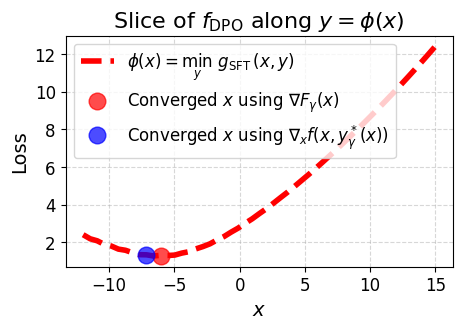

In [19]:
fig = plt.figure(figsize=(5, 3))

# Plot the curve
plt.plot(Xx, Z1_star, "--",label=r'$\phi(x) = \min_{y}~ g_{\mathrm{SFT}}(x, y)$',
         linewidth=4, color='red')

# Plot the scatter points
plt.plot(traj1[-1][0], dpo1.item(),"o", color='red', alpha=0.7,markersize=12, zorder=50,label=r"Converged $x$ using $\nabla F_\gamma(x)$")#, label=r"Converged $x$ using $\nabla F_\gamma(x)$")
plt.plot(traj2[-1][0], dpo2.item(),"o", color='blue',  alpha=0.7,markersize=12, zorder=50,label=r"Converged $x$ using $\nabla_x f(x,y_\gamma^*(x))$")#, label=r"Converged $x$ using $\nabla_x f_\{\text{DPO}(x,y_\gamma^*(x))$")

# Labels and title
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.title(r'Slice of $f_{\mathrm{DPO}}$ along $y = \phi(x)$', fontsize=16)

# Customize ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend
plt.legend(fontsize=12)

# plt.tight_layout()
plt.show()


In [20]:
# find y_g^*(x) for each x
Xx = np.linspace(-12, 15, 51)
Yyg = np.linspace(-12, 15, 51)
Value_function = np.linspace(-12, 15, 51)
model=SoftmaxNN()
for i in range(len(Xx)):
    x=Xx[i]
    model.set_params([x,Y_star_x[i]])
    min_LL_SFT(model,gam_inv = 0,num_epoch = 10)
    Yyg[i]=get_weight(model)[1]
    Value_function[i]=sft_loss(model).item()

In [21]:
# Plot loss landscape for f1, f2
w1_values = Xx #np.linspace(-10, 15, 51)
w2_values = Xx #np.linspace(-10, 15, 51)
W1, W2 = np.meshgrid(w1_values, w2_values)
loss_values_1 = np.zeros_like(W1)
loss_values_2 = np.zeros_like(W1)
loss_values_avg = np.zeros_like(W1)
f1_min =0.1
f2_min=0.1
favg_min = 1.0
f1_argmin = None
f2_argmin = None
favg_argmin = None
favg_f1 = None
favg_f2 = None

gam = 15

model = SoftmaxNN()

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        with torch.no_grad():
            model.hidden.weight = nn.Parameter(torch.tensor([W1[i, j], W2[i, j]]).float().unsqueeze(0).unsqueeze(0))
        outputs = model(X1)
        loss1=sft_loss(model)
        # loss1 = f1(logsoftmax(outputs.squeeze()), y)+ mu*torch.sum(model.hidden.weight.flatten()**2)
        loss_values_1[i, j] = loss1.item()
        loss2 = dpo_loss(model) #+ 0.1*torch.sum(model.hidden.weight.flatten()**2)
        # loss2 = dpo_loss(X2, yw, yl, model, model_ref, beta) + mu*torch.sum(model.hidden.weight.flatten()**2)
        loss_values_2[i, j] = loss2.item()
        loss_values_avg[i, j] = loss2.item()+gam*loss1.item()-gam*Value_function[j] # # assume v(x)=0
        if loss1.item() < f1_min:
            f1_min = loss1.item()
            f1_min_point = [loss1.item(), loss2.item()]
            f1_argmin = [W1[i, j], W2[i, j]]
        if loss2.item() < f2_min:
            f2_min = loss2.item()
            f2_min_point = [loss1.item(), loss2.item()]
            f2_argmin = [W1[i, j], W2[i, j]]
        if 0.5*loss1.item() + 0.5*loss2.item() < favg_min:
            favg_min = 0.5*loss1.item() + 0.5*loss2.item()
            favg_f1 = loss1.item()
            favg_f2 = loss2.item()

/var/folders/kj/5d0bqq494qlf0h4pndl_5crw0000gn/T/ipykernel_79569/428807193.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-o" (-> color='y'). The keyword argument will take precedence.
  p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',color="blue",markersize = 10,alpha = 0.5,label=r"F2SA")
/var/folders/kj/5d0bqq494qlf0h4pndl_5crw0000gn/T/ipykernel_79569/428807193.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-o" (-> color='y'). The keyword argument will take precedence.
  p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',color="red",markersize = 8,alpha = 0.5,label=r"PBGD-Free")


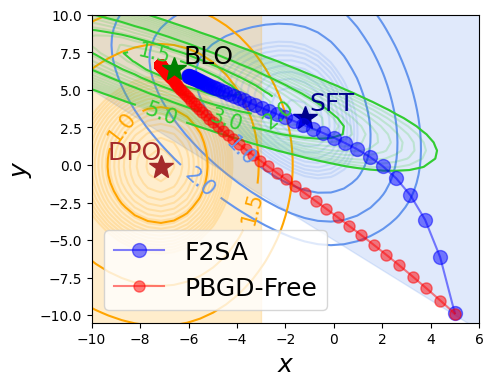

In [22]:
plt.figure(figsize=(5,4))
# Plot weight trajectory in accuracy space
xx = np.arange(-12, 15)
y1 = -xx
y2 = -xx+30

plt.xlim([-12, 8])
plt.ylim([-11, 12])

plt.contour(W1, W2, loss_values_1, levels=np.linspace(0, 0.8, 20), colors='cornflowerblue', alpha=0.2) #cmap='winter'
CS1 = plt.contour(W1, W2, loss_values_1, levels=[1e-1, 1,1.5,2, 10, 100], colors='cornflowerblue')
plt.clabel(CS1, inline=True, fontsize=15)
plt.contour(W1, W2, loss_values_2, levels=np.linspace(0.8, 1.2, 20), colors='orange', alpha=0.2)
CS2 = plt.contour(W1, W2, loss_values_2, levels=[0.5,0.8,1,1.5,2, 10,100], colors='orange')
plt.clabel(CS2, inline=True, fontsize=15)
plt.contour(W1, W2, loss_values_avg, levels=np.linspace(0, 5, 20), colors='limegreen', alpha=0.2)
CS3 = plt.contour(W1, W2, loss_values_avg, levels=[1,1.5,2, 3,5,100], colors='limegreen')
plt.clabel(CS3, inline=True, fontsize=15)
min_index1 = np.unravel_index(np.argmin(loss_values_1), loss_values_2.shape)
min_index2 = np.unravel_index(np.argmin(loss_values_2), loss_values_2.shape)
plt.plot(Xx[min_index1[1]],Xx[min_index1[0]],"*",markersize=18, color="darkblue")
plt.text(Xx[min_index1[1]] +0.2, Xx[min_index1[0]]+ 0.5, "SFT", fontsize=18, color="darkblue", zorder=100)
plt.plot(Xx[min_index2[1]],Xx[min_index2[0]],"*",markersize=18, color="brown")
plt.text(Xx[min_index2[1]] -2.2, Xx[min_index2[0]]+ 0.5, "DPO", fontsize=18, color="brown", zorder=100)


weight_traj = np.array(traj1)
p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',color="blue",markersize = 10,alpha = 0.5,label=r"F2SA")

weight_traj = np.array(traj2)
p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',color="red",markersize = 8,alpha = 0.5,label=r"PBGD-Free")

# pstar=plt.plot(weight_traj[:, 0][-1], weight_traj[:, 1][-1], 'r*', markersize=10)
p1= plt.fill_between(xx, y1-5, y2, color='cornflowerblue', alpha=0.2)
p2 = plt.fill_between(xx, y1=-12, y2=12, where=(xx<=-2.5), color='orange', alpha=0.2)

plt.plot(theta_1_star,theta_2_star,"*",markersize=18, color="green",zorder=100)
plt.text(theta_1_star + 0.4, theta_2_star + 0.4, "BLO", fontsize=18, color="k", zorder=100)
plt.xlim([-10,6])
plt.ylim([-10.5,10])

plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)
plt.legend(fontsize=18,loc="lower left")
# plt.legend([p0[0], p1, p2, pstar[0]], ['Trajectory', 'Perfect SFT Acc.', 'Perfect RLHF Acc.', 'Final Model'], fontsize=15)
plt.savefig(f'./weight_traj_dpo_sft.pdf', bbox_inches='tight', pad_inches=0)



/var/folders/kj/5d0bqq494qlf0h4pndl_5crw0000gn/T/ipykernel_79569/3320105262.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-o" (-> color='y'). The keyword argument will take precedence.
  p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',alpha = 0.8,color="pink")
/var/folders/kj/5d0bqq494qlf0h4pndl_5crw0000gn/T/ipykernel_79569/3320105262.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y-o" (-> color='y'). The keyword argument will take precedence.
  p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',alpha = 0.8,color="skyblue")


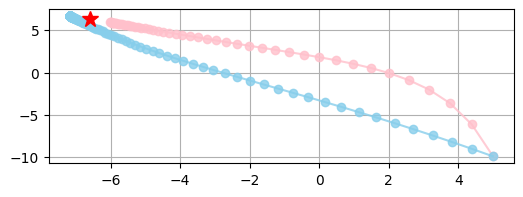

In [23]:
plt.figure(figsize=(6,2))
weight_traj = np.array(traj1)
p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',alpha = 0.8,color="pink")

weight_traj = np.array(traj2)
p0=plt.plot(weight_traj[:, 0][::100], weight_traj[:, 1][::100], 'y-o',alpha = 0.8,color="skyblue")

plt.plot(theta_1_star,theta_2_star,"*",markersize=12, color="r")
plt.grid("--")

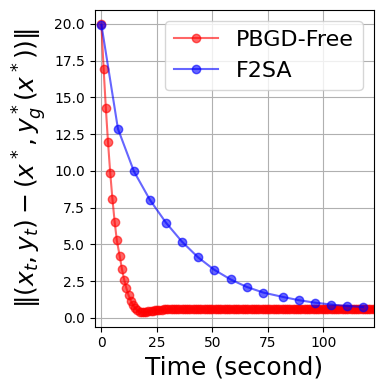

In [29]:
plt.figure(figsize=(4,4))

# Calculate distances for trajectory 1
traj1_array = np.array(traj1)
distances1 = np.sqrt((traj1_array[:, 0] - theta_1_star)**2 + (traj1_array[:, 1] - theta_2_star)**2)

# Calculate distances for trajectory 2
traj2_array = np.array(traj2)
distances2 = np.sqrt((traj2_array[:, 0] - theta_1_star)**2 + (traj2_array[:, 1] - theta_2_star)**2)

# Plot the convergence

plt.plot(time2[::300], distances2[::300], 'o-', alpha=0.6, color="r", label="PBGD-Free")
plt.plot(time1[::300], distances1[::300], 'o-', alpha=0.6, color="b", label="F2SA")

plt.grid("--")
# plt.title("Convergence to Optimal Point")
plt.xlabel("Time (second)",fontsize=18)
plt.ylabel(r"$\|(x_t,y_t)-(x^*,y_g^*(x^*)) \|$",fontsize=18)
plt.xlim([-3,max(time1)])
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig(f'./weight_conv_dpo_sft.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [25]:
# flatness
# find \nabla_y DPO(x,y)
model=SoftmaxNN()

gradient_y_list = []
delta_x_list = []

c=0.5
alpha = 1.5
x_list = []
for i in range(len(traj1)):
    if i%100 == 0:
        # param = traj1[i]
        x=x_yg_y_gam_list[i][0]
        y_g=x_yg_y_gam_list[i][1]
        y_gam=x_yg_y_gam_list[i][2]
        param=[x,y_g]
        x_list.append(x)
    else:
        continue
    
    ### find gradient_y_list
    model.set_params(param)
    model.train()
     # print(weight_gam)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=mu)
    
    loss_f = dpo_loss(model)
    loss = loss_f
    
    optimizer.zero_grad()
    loss.backward()
    
    # Manually freeze one weight (e.g., the 1st one)
    with torch.no_grad():
        # print(model.hidden.weight.grad)
        gradient_y_list.append(model.hidden.weight.grad[0, 0, 1].item())
    # print(model.hidden.weight.grad)
    

    ### find delta_x_list
    dpo_y_g = dpo_loss(model).item()
    
    model.set_params([x,y_gam])
    dpo_y_gam = dpo_loss(model).item()

    delta = np.abs(dpo_y_g-dpo_y_gam)-c*np.abs(y_g-y_gam)**alpha
    if dpo_y_g-dpo_y_gam<=0:
        print("Warning: dpo_y_g - dpo_y_gam <= 0")
    delta_x_list.append(max([delta,0]))

# plt.plot([np.abs(i) for i in gradient_y_list])
# plt.plot(delta_x_list)

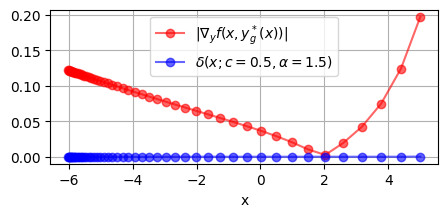

In [26]:
plt.figure(figsize = (5,2))
plt.plot(x_list,[np.abs(i) for i in gradient_y_list],"o-",color = "r",alpha = 0.6,label=r"$|\nabla_y f(x,y_g^*(x))|$")
plt.plot(x_list,delta_x_list,"o-",color = "b",alpha = 0.6,label=rf"$\delta(x;c={c},\alpha={alpha})$")
plt.grid("--")
plt.xlabel("x")
plt.legend()
plt.savefig(f'./flatness_vs_lipschitzness.pdf', bbox_inches='tight', pad_inches=0)

In [27]:
def find_y_gams(x_values, gam_inv,):
    Yyg_values = x_values.copy()
    y0 = 1
    model=SoftmaxNN()
    for i in range(len(x_values)):
        y0 = Yyg_values[i-1] if i>1 else  Yyg_values[i]
        epoch = 100
        model.set_params([x_values[i],y0])
        min_LL_SFT(model, gam_inv = gam_inv, num_epoch = epoch)
        Yyg_values[i]=get_weight(model)[1]
    return Yyg_values
    


def find_phi_x(x_values, Ygs):
    phi_x =[]
    model=SoftmaxNN()
    for x, y in zip(x_values, Ygs):
        model.set_params([x,y])
        phi_x.append(dpo_loss(model).item())
    return np.array(phi_x)

def find_dfy_x(x_values, Ygs):
    phi_x =[]
    model=SoftmaxNN()
    for x, y in zip(x_values, Ygs):
        model.set_params(param)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=mu)
        loss = dpo_loss(model)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            phi_x.append(model.hidden.weight.grad[0, 0, 1].item())
        # phi_x.append(dfy(x,y))
    return np.array(phi_x)


def find_F_gam_x(x_values, gam, Ygs, Ygams):
    F_gam_x =[]
    model=SoftmaxNN()
    for x, y, z in zip(x_values, Ygams, Ygs):
        model.set_params([x,y])
        loss = dpo_loss(model).item()+gam*sft_loss(model).item()
        model.set_params([x,z])
        loss -=gam*sft_loss(model).item()
        F_gam_x.append(loss)
    return np.array(F_gam_x)


In [28]:
######### Tighter bound

gam_list = np.logspace(-1,2, 10)
x_values = Xx
#np.linspace(0.35,0.4,21) #np.linspace(xlim[0],xlim[1],201)

y_dis = []
F_dis = []
dfy_s = []
for gam in gam_list:
    print(f"gam: {gam}")
    Ygs = find_y_gams(x_values, 0)
    Ygams = find_y_gams(x_values, 1/gam)
    y_dis.append(np.abs(Ygs-Ygams).max())

    phi_x = find_phi_x(x_values, Ygs)
    F_gam_x = find_F_gam_x(x_values, gam, Ygs, Ygams)
    F_dis.append(np.abs(phi_x-F_gam_x).max())

    dfy_ = find_dfy_x(x_values, Ygs)
    dfy_s.append(np.abs(dfy_).max())

    

y_dis = np.array(y_dis)
F_dis = np.array(F_dis)
dfy_s = np.array(dfy_s)
    

gam: 0.1
Innerloop: Epoch [20/100], Loss: 8.7891
Innerloop: Epoch [40/100], Loss: 8.6942
Innerloop: Epoch [60/100], Loss: 8.6000
Innerloop: Epoch [80/100], Loss: 8.5065
Innerloop: Epoch [100/100], Loss: 8.4139
Innerloop: Epoch [20/100], Loss: 8.2697
Innerloop: Epoch [40/100], Loss: 8.1789
Innerloop: Epoch [60/100], Loss: 8.0888
Innerloop: Epoch [80/100], Loss: 7.9994
Innerloop: Epoch [100/100], Loss: 7.9108
Innerloop: Epoch [20/100], Loss: 7.7924
Innerloop: Epoch [40/100], Loss: 7.7054
Innerloop: Epoch [60/100], Loss: 7.6191
Innerloop: Epoch [80/100], Loss: 7.5335
Innerloop: Epoch [100/100], Loss: 7.4485
Innerloop: Epoch [20/100], Loss: 7.3296
Innerloop: Epoch [40/100], Loss: 7.2463
Innerloop: Epoch [60/100], Loss: 7.1637
Innerloop: Epoch [80/100], Loss: 7.0817
Innerloop: Epoch [100/100], Loss: 7.0004
Innerloop: Epoch [20/100], Loss: 6.8811
Innerloop: Epoch [40/100], Loss: 6.8013
Innerloop: Epoch [60/100], Loss: 6.7222
Innerloop: Epoch [80/100], Loss: 6.6438
Innerloop: Epoch [100/100],


KeyboardInterrupt



In [ ]:
# Define colors for consistency
blue = "#1f77b4"
orange = "#ff7f0e"

alpha = 1.5
delta = max(delta_x_list)
c = 1
lf0= 0.2
mu = 0.02 # 2* reg_constant

plt.figure(figsize=(8.8,4.4))
plt.subplot(2,1,1)
plt.plot(gam_list,F_dis,color = blue , label="$\max_{x\in [0,1.5]}\|\phi(x)-F_\gamma(x) \|$")
plt.plot(gam_list,y_dis,color = orange , label="$\max_{x\in [0,1.5]}\|y_g^*(x)-y_\gamma^*(x) \|$")

plt.plot(gam_list,lf0/mu* gam_list**(-1),"--",color = blue) #, label="Upper bound")
plt.plot(gam_list,lf0**2/mu* gam_list**(-1),"--",color = orange) #, label="Upper bound")
plt.plot(gam_list,c*gam_list**(-alpha/(2-alpha))+delta,"--",color = "blue")
plt.plot(gam_list,c*gam_list**(-1/(2-alpha)),"--",color = "red") #, label="Upper bound")

plt.xlim([-0.1,15])
plt.ylim([0,1.7])
plt.legend(loc='upper right')
plt.title("Empirical vs. Theoretical Bounds")

plt.subplot(2,1,2)

plt.plot(gam_list,F_dis,color = blue )# , label="$\max_{x\in [0,1.5]}\|\phi(x)-F_\gamma(x) \|$")
plt.plot(gam_list,y_dis,color = orange )# , label="$\max_{x\in [0,1.5]}\|y_g^*(x)-y_\gamma^*(x) \|$")


plt.plot(gam_list, lf0**2 /mu * gam_list**(-1), "--", color=blue, 
         label="UB (Prop.1)$\\|\\phi(x) - F_\\gamma(x)\\|$")
plt.plot(gam_list, lf0/mu  * gam_list**(-1), "--", color=orange, 
         label="UB (Prop.1)$\\|y_g^*(x) - y_\\gamma^*(x)\\|$")
plt.plot(gam_list, c * gam_list**(-alpha/(2-alpha)) + delta, "--", color="blue", 
         label="UB (Lemm.1)$\\|\\phi(x) - F_\\gamma(x)\\|$")
plt.plot(gam_list, c * (gam_list**(-1/(2-alpha)) + delta**(1/2) * gam_list**(-1/2)), 
         "--", color="red", 
         label="UB (Lemm.1)$\\|y_g^*(x) - y_\\gamma^*(x)\\|$")

plt.xlim([-0.1,100])
plt.ylim([0,3])
from matplotlib.legend_handler import HandlerTuple
# Create dummy lines for the legend
line_blue = mlines.Line2D([], [], color=blue, linestyle="--")
line_orange = mlines.Line2D([], [], color=orange, linestyle="--")
line_blue2 = mlines.Line2D([], [], color="blue", linestyle="--")
line_red = mlines.Line2D([], [], color="red", linestyle="--")
# Combine both into one legend entry
plt.legend(
    [(line_blue2, line_red),(line_blue, line_orange)],
    ["Upper bounds in Lemma 1", #"UBs (Lem.1) for $\\|\\phi(x) - F_\\gamma(x)\\|$, $\\|y_g^*(x) - y_\\gamma^*(x)\\|$",
     "Upper bounds in Proposition 1"], #"UBs (Prop.1) for $\\|\\phi(x) - F_\\gamma(x)\\|$, $\\|y_g^*(x) - y_\\gamma^*(x)\\|$"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    handlelength=4  
)

# plt.legend()
plt.xlabel("$\gamma$")

# plt.savefig('plots/bounds.pdf',bbox_inches='tight')
plt.show()